In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import geopandas as gpd
import geopy.distance

from bokeh.io import output_file, show
from bokeh.models import HoverTool
from bokeh.plotting import figure

import datetime

import json
import requests
from config import google_api_key

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading CSV file
raw_data = pd.read_csv('Resources/NYPD_Motor_Vehicle_Collisions.csv', low_memory=False)

In [3]:
# Verifying csv file
raw_data.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,06/14/2019,0:00,BRONX,10461,40.836327,-73.827614,"(40.836327, -73.827614)",CROSBY AVENUE,BAISLEY AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4152765,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
1,06/14/2019,0:00,BROOKLYN,11207,40.685127,-73.906430,"(40.685127, -73.90643)",PILLING STREET,EVERGREEN AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4152260,Pick-up Truck,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,06/14/2019,0:00,BROOKLYN,11212,40.661655,-73.927950,"(40.661655, -73.92795)",NaN,NaN,950 RUTLAND ROAD,...,NaN,NaN,NaN,NaN,4151711,Sedan,NaN,NaN,NaN,NaN
3,06/14/2019,0:00,QUEENS,11413,40.675213,-73.737800,"(40.675213, -73.7378)",MERRICK BOULEVARD,232 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4151632,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,06/14/2019,0:00,NaN,NaN,40.887420,-73.894490,"(40.88742, -73.89449)",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4151943,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


In [4]:
# Opening shape files
nyc_zip = gpd.read_file('Resources/nyc_zip_bounderies/nyc_zip_bounderies.shp')
bike_lanes = gpd.read_file('Resources/bicycle_routes/geo_export_7a0584be-077c-4604-92bd-c514bdd8a794.shp')
nyc_boros = gpd.read_file('Resources/nyc_boro_bounderies/geo_export_ca011477-3aac-41b1-9a85-e2efd0b0a5ac.shp')

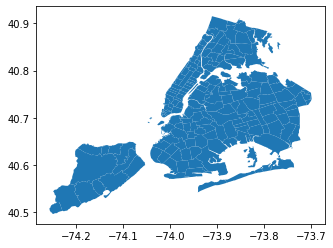

In [5]:
# Verifying shape file
nyc_zip.plot()

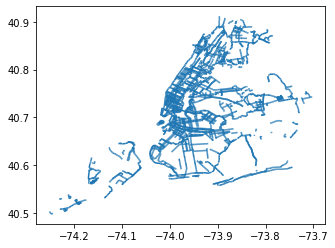

In [6]:
bike_lanes.plot()

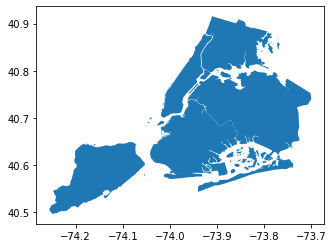

In [7]:
nyc_boros.plot()

## 1. Initial Data Exploration

In [8]:
r_c = raw_data.shape
print(f'The dataset contains {r_c[0]} rows and {r_c[1]} columns')

The dataset contains 1515798 rows and 29 columns


In [9]:
raw_data.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')

### For our analysis, we are interested interested in the following columns:

- 'DATE': Create a timeline of collisions
- 'TIME': Identify most dangerous and safest times of day for cyclists
- 'BOROUGH': Identify most dangerous and safest borough for cyclists
- 'ZIP CODE': Identify most dangerous and safest zip code for cyclists
        
**Q. Has any of these parameters change over time?**
        
- 'LATITUDE', 'LONGITUDE' and 'LOCATION': Visualize data and calculate distance of bike lane segments
 
- 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME': Find missing zip codes and borough information

- 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
- 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
- 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED'
- 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'

- 'CONTRIBUTING FACTOR VEHICLE 1': Determine most common cause of collisions (e.g. alcohol, speeding)

- 'UNIQUE KEY': Incident report (unique for each collision




In [10]:
raw_data.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,UNIQUE KEY
count,1.326905e+06,1.326905e+06,1.515781e+06,1.515767e+06,1.515798e+06,1.515798e+06,1.515798e+06,1.515798e+06,1.515798e+06,1.515798e+06,1.515798e+06
mean,4.069289e+01,-7.387571e+01,2.601385e-01,1.163108e-03,5.084978e-02,6.320103e-04,2.043346e-02,7.916622e-05,1.890080e-01,4.545461e-04,2.689817e+06
std,1.123116e+00,2.336980e+00,6.581859e-01,3.611451e-02,2.323244e-01,2.575418e-02,1.426249e-01,8.971034e-03,6.202007e-01,2.321172e-02,1.507874e+06
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01
25%,4.066867e+01,-7.397768e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.006395e+06
50%,4.072258e+01,-7.393039e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.394020e+06
75%,4.076781e+01,-7.386738e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.773169e+06
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.153109e+06


In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515798 entries, 0 to 1515797
Data columns (total 29 columns):
DATE                             1515798 non-null object
TIME                             1515798 non-null object
BOROUGH                          1060584 non-null object
ZIP CODE                         1060404 non-null object
LATITUDE                         1326905 non-null float64
LONGITUDE                        1326905 non-null float64
LOCATION                         1326905 non-null object
ON STREET NAME                   1223095 non-null object
CROSS STREET NAME                1024464 non-null object
OFF STREET NAME                  200548 non-null object
NUMBER OF PERSONS INJURED        1515781 non-null float64
NUMBER OF PERSONS KILLED         1515767 non-null float64
NUMBER OF PEDESTRIANS INJURED    1515798 non-null int64
NUMBER OF PEDESTRIANS KILLED     1515798 non-null int64
NUMBER OF CYCLIST INJURED        1515798 non-null int64
NUMBER OF CYCLIST KILLED        

In [12]:
# Calculating the number of missing values from columns of interest
raw_data.isna().sum()

DATE                                   0
TIME                                   0
BOROUGH                           455214
ZIP CODE                          455394
LATITUDE                          188893
LONGITUDE                         188893
LOCATION                          188893
ON STREET NAME                    292703
CROSS STREET NAME                 491334
OFF STREET NAME                  1315250
NUMBER OF PERSONS INJURED             17
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       3952
CONTRIBUTING FACTOR VEHICLE 2     202139
CONTRIBUTING FACTOR VEHICLE 3    1418108
CONTRIBUTING FACTOR VEHICLE 4    1495490
CONTRIBUTING FACTOR VEHICLE 5    1510629
UNIQUE KEY                             0
VEHICLE TYPE COD

In [13]:
# Removing round brackets from coordinates
raw_data['LOCATION'] = raw_data['LOCATION'].str.strip('()')
raw_data.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,06/14/2019,0:00,BRONX,10461,40.836327,-73.827614,"40.836327, -73.827614",CROSBY AVENUE,BAISLEY AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4152765,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
1,06/14/2019,0:00,BROOKLYN,11207,40.685127,-73.906430,"40.685127, -73.90643",PILLING STREET,EVERGREEN AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4152260,Pick-up Truck,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,06/14/2019,0:00,BROOKLYN,11212,40.661655,-73.927950,"40.661655, -73.92795",NaN,NaN,950 RUTLAND ROAD,...,NaN,NaN,NaN,NaN,4151711,Sedan,NaN,NaN,NaN,NaN
3,06/14/2019,0:00,QUEENS,11413,40.675213,-73.737800,"40.675213, -73.7378",MERRICK BOULEVARD,232 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4151632,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,06/14/2019,0:00,NaN,NaN,40.887420,-73.894490,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4151943,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


In [14]:
# Dropping columns we're not interested in
collisions = raw_data.drop(['OFF STREET NAME', 
                 'CONTRIBUTING FACTOR VEHICLE 2', 
                 'CONTRIBUTING FACTOR VEHICLE 3', 
                 'CONTRIBUTING FACTOR VEHICLE 4', 
                 'CONTRIBUTING FACTOR VEHICLE 5', 
                 'VEHICLE TYPE CODE 2', 
                 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'], axis=1)

In [15]:
collisions.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,UNIQUE KEY,VEHICLE TYPE CODE 1
0,06/14/2019,0:00,BRONX,10461,40.836327,-73.827614,"40.836327, -73.827614",CROSBY AVENUE,BAISLEY AVENUE,0.0,0.0,0,0,0,0,0,0,Turning Improperly,4152765,Station Wagon/Sport Utility Vehicle
1,06/14/2019,0:00,BROOKLYN,11207,40.685127,-73.906430,"40.685127, -73.90643",PILLING STREET,EVERGREEN AVENUE,0.0,0.0,0,0,0,0,0,0,Lane Marking Improper/Inadequate,4152260,Pick-up Truck
2,06/14/2019,0:00,BROOKLYN,11212,40.661655,-73.927950,"40.661655, -73.92795",NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,4151711,Sedan
3,06/14/2019,0:00,QUEENS,11413,40.675213,-73.737800,"40.675213, -73.7378",MERRICK BOULEVARD,232 STREET,0.0,0.0,0,0,0,0,0,0,Unspecified,4151632,Station Wagon/Sport Utility Vehicle
4,06/14/2019,0:00,NaN,NaN,40.887420,-73.894490,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,4151943,Station Wagon/Sport Utility Vehicle


In [16]:
# Converting 'DATE' column to datetime object
#cyclist_collisions['DATE'] = pd.to_datetime(cyclist_collisions['DATE'])

In [17]:
collisions.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,UNIQUE KEY,VEHICLE TYPE CODE 1
0,06/14/2019,0:00,BRONX,10461,40.836327,-73.827614,"40.836327, -73.827614",CROSBY AVENUE,BAISLEY AVENUE,0.0,0.0,0,0,0,0,0,0,Turning Improperly,4152765,Station Wagon/Sport Utility Vehicle
1,06/14/2019,0:00,BROOKLYN,11207,40.685127,-73.906430,"40.685127, -73.90643",PILLING STREET,EVERGREEN AVENUE,0.0,0.0,0,0,0,0,0,0,Lane Marking Improper/Inadequate,4152260,Pick-up Truck
2,06/14/2019,0:00,BROOKLYN,11212,40.661655,-73.927950,"40.661655, -73.92795",NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,4151711,Sedan
3,06/14/2019,0:00,QUEENS,11413,40.675213,-73.737800,"40.675213, -73.7378",MERRICK BOULEVARD,232 STREET,0.0,0.0,0,0,0,0,0,0,Unspecified,4151632,Station Wagon/Sport Utility Vehicle
4,06/14/2019,0:00,NaN,NaN,40.887420,-73.894490,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,4151943,Station Wagon/Sport Utility Vehicle


In [18]:
min_date = collisions['DATE'].min()
max_date = collisions['DATE'].max()
print(f'Dataset ranges from {min_date} to {max_date}')

Dataset ranges from 01/01/2013 to 12/31/2018


In [19]:
# Determing missing values
collisions.isna().sum()

DATE                                  0
TIME                                  0
BOROUGH                          455214
ZIP CODE                         455394
LATITUDE                         188893
LONGITUDE                        188893
LOCATION                         188893
ON STREET NAME                   292703
CROSS STREET NAME                491334
NUMBER OF PERSONS INJURED            17
NUMBER OF PERSONS KILLED             31
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      3952
UNIQUE KEY                            0
VEHICLE TYPE CODE 1                4854
dtype: int64

In [20]:
# For missing values in NUMBER OF PERSONS INJURED and NUMBER OF PERSONS KILLED, we will replace with 0
collisions['NUMBER OF PERSONS INJURED'].fillna(0, inplace=True)
collisions['NUMBER OF PERSONS KILLED'].fillna(0, inplace=True)

In [22]:
collisions.isna().sum()

DATE                                  0
TIME                                  0
BOROUGH                          455214
ZIP CODE                         455394
LATITUDE                         188893
LONGITUDE                        188893
LOCATION                         188893
ON STREET NAME                   292703
CROSS STREET NAME                491334
NUMBER OF PERSONS INJURED             0
NUMBER OF PERSONS KILLED              0
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      3952
UNIQUE KEY                            0
VEHICLE TYPE CODE 1                4854
dtype: int64

**We have several values missing for Zip Code, Borough and Lat/Lon data. We will use the Google Geolocation API do a reverse geolocation to retrieve missing values using location (lat/lng) data if available.**


In [24]:
# Creating a new dataframe containing records which include lat/lon data but no other geolocation data
collision_loc = collisions[collisions['LOCATION'].notna()]
#missing_streets_df = collisions[cyclist_collisions['ON STREET NAME'].isna()]
#missing_geodata_df = missing_streets_df[missing_streets_df['ZIP CODE'].isna()]
#missing_geodata_df.head() # New dataframe containing all missing zips

In [25]:
# Dataframe contains only records which include location data (Lat/Lng)
collision_loc.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,UNIQUE KEY,VEHICLE TYPE CODE 1
0,06/14/2019,0:00,BRONX,10461,40.836327,-73.827614,"40.836327, -73.827614",CROSBY AVENUE,BAISLEY AVENUE,0.0,0.0,0,0,0,0,0,0,Turning Improperly,4152765,Station Wagon/Sport Utility Vehicle
1,06/14/2019,0:00,BROOKLYN,11207,40.685127,-73.906430,"40.685127, -73.90643",PILLING STREET,EVERGREEN AVENUE,0.0,0.0,0,0,0,0,0,0,Lane Marking Improper/Inadequate,4152260,Pick-up Truck
2,06/14/2019,0:00,BROOKLYN,11212,40.661655,-73.927950,"40.661655, -73.92795",NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,4151711,Sedan
3,06/14/2019,0:00,QUEENS,11413,40.675213,-73.737800,"40.675213, -73.7378",MERRICK BOULEVARD,232 STREET,0.0,0.0,0,0,0,0,0,0,Unspecified,4151632,Station Wagon/Sport Utility Vehicle
4,06/14/2019,0:00,NaN,NaN,40.887420,-73.894490,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,4151943,Station Wagon/Sport Utility Vehicle


In [73]:
collision_loc.shape

(1326905, 20)

In [26]:
# Dataframe contains  records with location data (Lat/Lng) but no zip codes
collision_no_zip = collision_loc[collision_loc['ZIP CODE'].isna()]
collision_no_zip.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,UNIQUE KEY,VEHICLE TYPE CODE 1
4,06/14/2019,0:00,NaN,NaN,40.887420,-73.894490,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,4151943,Station Wagon/Sport Utility Vehicle
6,06/14/2019,0:00,NaN,NaN,40.667350,-73.769940,"40.66735, -73.76994",BELT PARKWAY,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,4151046,Sedan
7,06/14/2019,0:05,NaN,NaN,40.677032,-73.824684,"40.677032, -73.824684",114 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Passing or Lane Usage Improper,4151192,Station Wagon/Sport Utility Vehicle
9,06/14/2019,0:09,NaN,NaN,40.660072,-73.939740,"40.660072, -73.93974",RUTLAND ROAD,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,4151253,Station Wagon/Sport Utility Vehicle
11,06/14/2019,0:14,NaN,NaN,40.681675,-73.879135,"40.681675, -73.879135",FULTON STREET,NaN,3.0,0.0,0,0,0,0,3,0,Failure to Yield Right-of-Way,4151079,Sedan


In [27]:
locations = collision_no_zip[['LOCATION']]
locations.head()

,LOCATION
4,"40.88742, -73.89449"
6,"40.66735, -73.76994"
7,"40.677032, -73.824684"
9,"40.660072, -73.93974"
11,"40.681675, -73.879135"


In [28]:
coords = list(locations['LOCATION'])
coords[0:10]

['40.88742, -73.89449',
 '40.66735, -73.76994',
 '40.677032, -73.824684',
 '40.660072, -73.93974',
 '40.681675, -73.879135',
 '40.77008, -73.94784',
 '40.757065, -73.73904',
 '40.73283, -73.97415',
 '40.66755, -73.773575',
 '40.711227, -73.72826']

In [29]:
url = 'https://maps.googleapis.com/maps/api/geocode/json?'

latlng = coords[0:10]

street_addresses = []
boroughs = []
zipcodes = []
full_addresses = []


for latlng in latlng:
    parameters = dict(latlng = latlng, key = google_api_key)

    resp = requests.get(url=url, params=parameters)
    
    data = resp.json()
    print(data)
    try:
        street_addresses.append(data['results'][1]['address_components'][1]['long_name'])
        boroughs.append(data['results'][1]['address_components'][3]['long_name'])
        zipcodes.append(data['results'][1]['address_components'][6]['long_name'])
        full_addresses.append(data['results'][1]['formatted_address'])
    except:
        print("No Data found")
        street_addresses.append('NaN')
        boroughs.append('NaN')
        zipcodes.append('NaN')
        full_addresses.append('NaN')
    


{'plus_code': {'compound_code': 'V4P4+X6 New York, NY, USA', 'global_code': '87G8V4P4+X6'}, 'results': [{'address_components': [{'long_name': '189', 'short_name': '189', 'types': ['street_number']}, {'long_name': 'Van Cortlandt Avenue West', 'short_name': 'Van Cortlandt Ave W', 'types': ['route']}, {'long_name': 'The Bronx', 'short_name': 'The Bronx', 'types': ['political', 'sublocality', 'sublocality_level_1']}, {'long_name': 'Bronx County', 'short_name': 'Bronx County', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'New York', 'short_name': 'NY', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '10471', 'short_name': '10471', 'types': ['postal_code']}], 'formatted_address': '189 Van Cortlandt Ave W, The Bronx, NY 10471, USA', 'geometry': {'location': {'lat': 40.8876362, 'lng': -73.89413789999999}, 'location_type': 'ROOFTOP', 'viewport': {'northeast': {'l

In [30]:
print(full_addresses)

['189 Van Cortlandt Ave W, The Bronx, NY 10471, USA', '169-37 N Conduit Ave, Jamaica, NY 11434, USA', '114-2 Rockaway Blvd, South Ozone Park, NY 11420, USA', '621 Rutland Rd, Brooklyn, NY 11203, USA', '186 Norwood Ave, Brooklyn, NY 11208, USA', '542 E 79th St, New York, NY 10075, USA', '24208 Horace Harding Expy, Little Neck, NY 11362, USA', 'FDR Dr, New York, NY 10010, USA', 'Belt Pkwy, Jamaica, NY 11434, USA', 'Cross Island Pkwy, Queens Village, NY 11429, USA']


In [31]:
print(zipcodes)

['10471', 'United States', 'United States', 'United States', 'United States', 'United States', 'United States', '10010', '11434', '11429']


In [32]:
# Copy dataframe
found_locations = locations.copy(deep=True)

found_locations.head()

,LOCATION
4,"40.88742, -73.89449"
6,"40.66735, -73.76994"
7,"40.677032, -73.824684"
9,"40.660072, -73.93974"
11,"40.681675, -73.879135"


In [33]:
found_locations['FULL ADDRESS'] = ""
found_locations['FULL ADDRESS'] = np.nan
found_locations.head()

,LOCATION,FULL ADDRESS
4,"40.88742, -73.89449",NaN
6,"40.66735, -73.76994",NaN
7,"40.677032, -73.824684",NaN
9,"40.660072, -73.93974",NaN
11,"40.681675, -73.879135",NaN


In [34]:
#found_locations['BOROUGH'][0:len(boroughs)] = boroughs
#found_locations['ZIP CODE'][0:len(zipcodes)] = zipcodes
found_locations['FULL ADDRESS'][0:len(zipcodes)] = full_addresses
found_locations.head(len(boroughs))

,LOCATION,FULL ADDRESS
4,"40.88742, -73.89449","189 Van Cortlandt Ave W, The Bronx, NY 10471, USA"
6,"40.66735, -73.76994","169-37 N Conduit Ave, Jamaica, NY 11434, USA"
7,"40.677032, -73.824684","114-2 Rockaway Blvd, South Ozone Park, NY 1142..."
9,"40.660072, -73.93974","621 Rutland Rd, Brooklyn, NY 11203, USA"
11,"40.681675, -73.879135","186 Norwood Ave, Brooklyn, NY 11208, USA"
12,"40.77008, -73.94784","542 E 79th St, New York, NY 10075, USA"
13,"40.757065, -73.73904","24208 Horace Harding Expy, Little Neck, NY 113..."
16,"40.73283, -73.97415","FDR Dr, New York, NY 10010, USA"
21,"40.66755, -73.773575","Belt Pkwy, Jamaica, NY 11434, USA"
22,"40.711227, -73.72826","Cross Island Pkwy, Queens Village, NY 11429, USA"


In [35]:
i = found_locations.columns.get_loc('FULL ADDRESS')
df2 = found_locations['FULL ADDRESS'].str.split(",", n=3, expand=True)
temp_zips = pd.concat([found_locations.iloc[:, :i], df2, found_locations.iloc[:, i+1:]], axis=1)
temp_zips.head()

,LOCATION,0,1,2,3
4,"40.88742, -73.89449",189 Van Cortlandt Ave W,The Bronx,NY 10471,USA
6,"40.66735, -73.76994",169-37 N Conduit Ave,Jamaica,NY 11434,USA
7,"40.677032, -73.824684",114-2 Rockaway Blvd,South Ozone Park,NY 11420,USA
9,"40.660072, -73.93974",621 Rutland Rd,Brooklyn,NY 11203,USA
11,"40.681675, -73.879135",186 Norwood Ave,Brooklyn,NY 11208,USA


In [36]:
i = temp_zips.columns.get_loc(2)
df2 = temp_zips[2].str.split(" ", n=2, expand=True)
found_zips = pd.concat([temp_zips.iloc[:, :i], df2, temp_zips.iloc[:, i+1:]], axis=1)
found_zips.head()
found_zips.rename(columns={2: 'FOUND ZIPS'}, inplace=True)
found_zips.drop([0, 1, 0, 1, 3], axis=1, inplace=True)
found_zips.head()


,LOCATION,FOUND ZIPS
4,"40.88742, -73.89449",10471
6,"40.66735, -73.76994",11434
7,"40.677032, -73.824684",11420
9,"40.660072, -73.93974",11203
11,"40.681675, -73.879135",11208


In [55]:
raw_data[raw_data['LOCATION'] == '40.88742, -73.89449']['ZIP CODE'] = found_zips[found_zips['LOCATION'] == '40.88742, -73.89449']['FOUND ZIPS']

In [69]:
raw_data.loc[raw_data['LOCATION'] == '40.88742, -73.89449']['ZIP CODE']

#df.loc[df['B'] == 3, 'A']

4         NaN
7812      NaN
16366     NaN
25573     NaN
27472     NaN
34784     NaN
60238     NaN
61402     NaN
64264     NaN
66652     NaN
100449    NaN
104529    NaN
113141    NaN
120493    NaN
122354    NaN
130941    NaN
139210    NaN
145288    NaN
155079    NaN
158347    NaN
180724    NaN
189623    NaN
194307    NaN
194379    NaN
203283    NaN
206029    NaN
208935    NaN
218966    NaN
234608    NaN
241158    NaN
         ... 
313997    NaN
328085    NaN
329404    NaN
347429    NaN
355977    NaN
360022    NaN
360069    NaN
367105    NaN
370251    NaN
377742    NaN
391213    NaN
394548    NaN
404954    NaN
405050    NaN
445849    NaN
449007    NaN
472422    NaN
479939    NaN
500650    NaN
512803    NaN
523204    NaN
577829    NaN
591712    NaN
591719    NaN
592268    NaN
602395    NaN
605751    NaN
618350    NaN
635080    NaN
640295    NaN
Name: ZIP CODE, Length: 69, dtype: object

In [68]:
found_zips.loc[found_zips['LOCATION'] == '40.88742, -73.89449', 'FOUND ZIPS']

#df.loc[df['B'] == 3, 'A']

4         10471
7812       None
16366      None
25573      None
27472      None
34784      None
60238      None
61402      None
64264      None
66652      None
100449     None
104529     None
113141     None
120493     None
122354     None
130941     None
139210     None
145288     None
155079     None
158347     None
180724     None
189623     None
194307     None
194379     None
203283     None
206029     None
208935     None
218966     None
234608     None
241158     None
          ...  
313997     None
328085     None
329404     None
347429     None
355977     None
360022     None
360069     None
367105     None
370251     None
377742     None
391213     None
394548     None
404954     None
405050     None
445849     None
449007     None
472422     None
479939     None
500650     None
512803     None
523204     None
577829     None
591712     None
591719     None
592268     None
602395     None
605751     None
618350     None
635080     None
640295     None
Name: FOUND ZIPS, Length

In [54]:
found_zips['FOUND ZIPS']

4          10471
6          11434
7          11420
9          11203
11         11208
12         10075
13         11362
16         10010
21         11434
22         11429
23          None
28          None
32          None
33          None
42          None
46          None
47          None
51          None
61          None
62          None
63          None
65          None
66          None
72          None
83          None
90          None
91          None
92          None
93          None
98          None
           ...  
1515266     None
1515290     None
1515326     None
1515327     None
1515332     None
1515363     None
1515381     None
1515382     None
1515384     None
1515393     None
1515450     None
1515461     None
1515462     None
1515469     None
1515505     None
1515519     None
1515533     None
1515534     None
1515615     None
1515625     None
1515628     None
1515630     None
1515651     None
1515672     None
1515681     None
1515725     None
1515745     None
1515749     No

In [39]:
print(raw_data.shape)
print(found_zips.shape)

(1515798, 29)
(293464, 2)


In [40]:
merge_test = pd.merge(raw_data, found_zips, how='inner', on=['LOCATION'])

In [41]:

print(merge_test.shape)


(16430207, 30)


In [419]:
test = test_result[test_result['FOUND ZIPS'].notna()]
test['ZIP CODE'] = test['FOUND ZIPS']


In [420]:
test

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,FOUND ZIPS
48,06/14/2019,0:00,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4151943,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,10471
117,06/02/2019,17:40,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4144085,Sedan,NaN,NaN,NaN,NaN,10471
186,05/19/2019,13:30,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4135868,Sedan,Sedan,NaN,NaN,NaN,10471
255,05/05/2019,4:23,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4125909,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,10471
324,05/02/2019,8:38,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4124764,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,10471
393,04/17/2019,0:25,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4116156,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,10471
462,03/05/2019,8:45,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4092014,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,10471
531,03/02/2019,12:00,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4089808,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,10471
600,02/26/2019,19:00,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,Unspecified,Unspecified,NaN,4087665,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,Station Wagon/Sport Utility Vehicle,NaN,10471
669,02/21/2019,0:45,NaN,10471,40.887420,-73.89449,"40.88742, -73.89449",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,4084515,Sedan,NaN,NaN,NaN,NaN,10471


In [454]:
test_result.shape

(15476664, 30)

---

In [370]:
zip_code = np.array(found_zips['FOUND ZIPS'])
location = np.array(found_zips['LOCATION'])

In [371]:
# Creating a dictionary to fill-in values in main dataframe
location_dict = dict(zip(zip_code, location))
location_dict

TypeError: 'Series' object is not callable

In [237]:
# Testing values
#street_address = data['results'][1]['address_components'][1]['long_name']
#boro = data['results'][1]['address_components'][2]['long_name']
#zipcode = data['results'][1]['address_components'][6]['long_name']

In [25]:
# Exporting csv
#missing_geodata_df.to_csv('Resources/missing_geodata.csv', index=False)

In [428]:
ids = raw_data["LOCATION"]
duplicates = raw_data[ids.isin(ids[ids.duplicated()])].sort_values("LOCATION", ascending=False)

In [433]:
duplicates

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
429224,07/25/2017,10:05,NaN,NaN,41.126150,-73.713530,"41.12615, -73.71353",NaN,NaN,410 MAIN STREET,...,Unspecified,NaN,NaN,NaN,3718980,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
431439,07/22/2017,23:00,NaN,NaN,41.126150,-73.713530,"41.12615, -73.71353",NaN,NaN,410 MAIN STREET,...,NaN,NaN,NaN,NaN,3717295,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
428792,07/26/2017,16:21,BROOKLYN,11239,41.126150,-73.713530,"41.12615, -73.71353",NaN,NaN,360 GATEWAY DRIVE,...,Unspecified,NaN,NaN,NaN,3719109,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
431356,07/22/2017,1:20,NaN,NaN,41.126150,-73.713530,"41.12615, -73.71353",NaN,NaN,410 MAIN STREET,...,Unspecified,NaN,NaN,NaN,4024533,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
429046,07/26/2017,23:35,BROOKLYN,11201,41.126150,-73.713530,"41.12615, -73.71353",NaN,NaN,29 FLATBUSH AVENUE EXTENSION,...,Following Too Closely,NaN,NaN,NaN,3719800,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
720043,04/23/2016,13:15,NaN,NaN,41.061634,-73.970660,"41.061634, -73.97066",Van Wyck Rd,NaN,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,3423014,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
739355,03/24/2016,15:30,NaN,NaN,41.061634,-73.970660,"41.061634, -73.97066",Van Wyck Rd,NaN,NaN,...,Unspecified,NaN,NaN,NaN,3428278,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
376968,10/16/2017,16:15,BRONX,10471,40.912884,-73.902500,"40.912884, -73.9025",NaN,NaN,6301 RIVERDALE AVENUE,...,NaN,NaN,NaN,NaN,3771684,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
156387,09/28/2018,10:00,BRONX,10471,40.912884,-73.902500,"40.912884, -73.9025",NaN,NaN,6301 RIVERDALE AVENUE,...,Driver Inexperience,NaN,NaN,NaN,4026382,Chassis Cab,Sedan,NaN,NaN,NaN
532692,02/14/2017,17:00,BRONX,10471,40.912884,-73.902500,"40.912884, -73.9025",NaN,NaN,6301 RIVERDALE AVENUE,...,Unspecified,NaN,NaN,NaN,3615719,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


In [434]:
#duplicates.groupby('LOCATION').ffill().bfill()


,LOCATION,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
429224,"41.12615, -73.71353",07/25/2017,10:05,BROOKLYN,11239,41.126150,-73.713530,Van Wyck Rd,RIVERDALE AVENUE,410 MAIN STREET,...,Unspecified,Unspecified,Unspecified,Unspecified,3718980,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
431439,"41.12615, -73.71353",07/22/2017,23:00,BROOKLYN,11239,41.126150,-73.713530,Van Wyck Rd,RIVERDALE AVENUE,410 MAIN STREET,...,Unspecified,Unspecified,Unspecified,Unspecified,3717295,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
428792,"41.12615, -73.71353",07/26/2017,16:21,BROOKLYN,11239,41.126150,-73.713530,Van Wyck Rd,RIVERDALE AVENUE,360 GATEWAY DRIVE,...,Unspecified,Unspecified,Unspecified,Unspecified,3719109,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
431356,"41.12615, -73.71353",07/22/2017,1:20,BROOKLYN,11239,41.126150,-73.713530,Van Wyck Rd,RIVERDALE AVENUE,410 MAIN STREET,...,Unspecified,Unspecified,Unspecified,Unspecified,4024533,Sedan,Station Wagon/Sport Utility Vehicle,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
429046,"41.12615, -73.71353",07/26/2017,23:35,BROOKLYN,11201,41.126150,-73.713530,Van Wyck Rd,RIVERDALE AVENUE,29 FLATBUSH AVENUE EXTENSION,...,Following Too Closely,Unspecified,Unspecified,Unspecified,3719800,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
720043,"41.061634, -73.97066",04/23/2016,13:15,BRONX,10471,41.061634,-73.970660,Van Wyck Rd,RIVERDALE AVENUE,6301 RIVERDALE AVENUE,...,Driver Inattention/Distraction,Unspecified,Unspecified,Unspecified,3423014,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
739355,"41.061634, -73.97066",03/24/2016,15:30,BRONX,10471,41.061634,-73.970660,Van Wyck Rd,RIVERDALE AVENUE,6301 RIVERDALE AVENUE,...,Unspecified,Unspecified,Unspecified,Unspecified,3428278,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
376968,"40.912884, -73.9025",10/16/2017,16:15,BRONX,10471,40.912884,-73.902500,WEST 263 STREET,RIVERDALE AVENUE,6301 RIVERDALE AVENUE,...,Driver Inexperience,Unspecified,Unspecified,Unspecified,3771684,PASSENGER VEHICLE,Sedan,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
156387,"40.912884, -73.9025",09/28/2018,10:00,BRONX,10471,40.912884,-73.902500,WEST 263 STREET,RIVERDALE AVENUE,6301 RIVERDALE AVENUE,...,Driver Inexperience,Unspecified,Unspecified,Unspecified,4026382,Chassis Cab,Sedan,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle
532692,"40.912884, -73.9025",02/14/2017,17:00,BRONX,10471,40.912884,-73.902500,WEST 263 STREET,RIVERDALE AVENUE,6301 RIVERDALE AVENUE,...,Unspecified,Unspecified,Unspecified,Unspecified,3615719,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,Station Wagon/Sport Utility Vehicle


In [436]:
#test['ZIP CODE'].isna().sum()

0

In [ ]:
#duplicates.ffill(axis = 0)